# Réseau de neurone et série temporelle 

La relation entre les réseaux de neurones et les séries temporelles repose sur la capacité des réseaux neuronaux 
à **modéliser des dépendances temporelles et à prédire des valeurs futures en fonction des observations passées**.

# 1) Réseau a une seule couche : Perceptron

## a) Définition 

Le Perceptron à une seule couche (ou Perceptron simple) est un modèle de base des réseaux de neurones artificiels. Il s’agit d’un **classificateur linéaire** capable de séparer des données en deux classes grâce à une **fonction de seuil**. Cette fonction permet de prendre une **décision binaire**.

## b) Architecture

In [20]:
from IPython.display import Image, display

# Afficher l'image à partir de l'URL
url = "https://otexts.com/fpp3/figs/nnet1-1.png"
display(Image(url=url))

## c) Description et formule 

Soit **x** = $( (x_1, x_2, x_3, x_4)^T )$ le vecteur d'entrée et **w** = $( (w_1, w_2, w_3, w_4)^T )$ le vecteur des poids associés aux connexions entre l'entrée et la sortie. On suppose qu'il y a un biais **b** et une fonction d'activation **f**.

L'équation du réseau est donnée par :

$$
y = f\left( \sum_{i=1}^4 w_i x_i + b \right)
$$

où :
- $(x_i)$ représente les entrées $((i \in \{1, 2, 3, 4\}))$,
- $(w_i)$ représente les poids associés,
- $(b)$ est le biais,
- $(f)$ est la fonction d'activation appliquée à la somme pondérée des entrées.


Si aucune fonction d'activation n'est précisée, on suppose une activation linéaire $((f(x) = x))$, ce qui donne :

$$
y = \sum_{i=1}^4 w_i x_i + b
$$

Dans un processus autorégressif, cela correspond à :

$$
y_t = f\left( \sum_{k=1}^4 w_k y_{t-k} + b \right)
$$

où :
- $(y_t)$ est la valeur prédite à l'instant $(t)$,
- $(y_{t-k} = x_k)$ sont les **4 dernières valeurs** de la série temporelle.

Ce réseau correspond à un **perceptron simple** avec une seule couche de sortie.

## d) Application à notre série 

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np 
import matplotlib as plt

In [7]:
# Charger le fichier Excel au lieu d'utiliser read_csv
df = pd.read_excel('Copie de bank1.xlsx', parse_dates=['DATE'], index_col='DATE')
#df = pd.read_excel('C:/Users/Scolaire/Documents/Prevition temporelle/data.xlsx', parse_dates=['DATE'], index_col='DATE')
# Vérifiez que les données ont été correctement chargées
print(df.head())

               Account No               TRANSACTION DETAILS  CHQ.NO.  \
DATE                                                                   
2017-06-29  409000611074'  TRF FROM  Indiaforensic SERVICES      NaN   
2017-07-05  409000611074'  TRF FROM  Indiaforensic SERVICES      NaN   
2017-07-18  409000611074'        FDRL/INTERNAL FUND TRANSFE      NaN   
2017-08-01  409000611074'   TRF FRM  Indiaforensic SERVICES      NaN   
2017-08-16  409000611074'        FDRL/INTERNAL FUND TRANSFE      NaN   

           VALUE DATE  WITHDRAWAL AMT  DEPOSIT AMT  BALANCE AMT  .  
DATE                                                                
2017-06-29 2017-06-29             NaN    1000000.0    1000000.0  .  
2017-07-05 2017-07-05             NaN    1000000.0    2000000.0  .  
2017-07-18 2017-07-18             NaN     500000.0    2500000.0  .  
2017-08-01 2017-08-01             NaN    3000000.0    5500000.0  .  
2017-08-16 2017-08-16             NaN     500000.0    6000000.0  .  


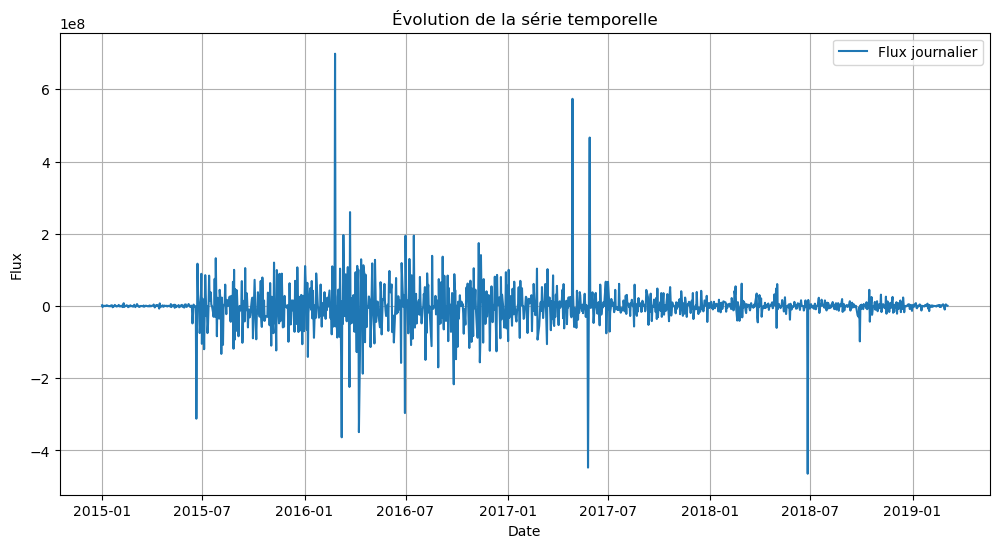

In [15]:
import matplotlib.pyplot as plt

# Remplace les valeurs manquantes par 0 sans utiliser inplace=True
df['DEPOSIT AMT'] = df['DEPOSIT AMT'].fillna(0)
df['WITHDRAWAL AMT'] = df['WITHDRAWAL AMT'].fillna(0)

# Création de la colonne 'flux' (dépôts - retraits)
df['flux'] = df['DEPOSIT AMT'] - df['WITHDRAWAL AMT']

# Agrégation des flux par jour
flux_per_day = df.groupby(df.index).agg({'flux': 'sum'})

# Vérifier le type de l'index
if not isinstance(flux_per_day.index, pd.DatetimeIndex):
    flux_per_day.index = pd.to_datetime(flux_per_day.index)  # Convertir en format datetime

# Vérifier si la colonne "flux" existe
if "flux" not in flux_per_day.columns:
    raise ValueError("La colonne 'flux' n'existe pas dans le DataFrame.")

# Tracer la série temporelle
plt.figure(figsize=(12, 6))
plt.plot(flux_per_day.index, flux_per_day['flux'], label='Flux journalier')
plt.xlabel('Date')
plt.ylabel('Flux')
plt.title('Évolution de la série temporelle')
plt.legend()
plt.grid()
plt.show()

## Stationnarisation de notre série 

📌 Pourquoi ?

Un réseau de neurones apprend à partir de patterns récurrents. Or, une série non stationnaire (avec tendance ou saisonnalité) contient des composantes qui évoluent dans le temps, ce qui peut fausser l’apprentissage.
La stationnarisation **stabilise la moyenne et la variance**, permettant au modèle de mieux apprendre les **relations sous-jacentes**.

In [17]:
# nous allons rendre notre serie stationnaire 
flux_stationary = flux_per_day['flux'].diff().dropna()
from statsmodels.tsa.stattools import adfuller
result = adfuller(flux_stationary)
print(f"Valeur p : {result[1]}")


Valeur p : 2.658496371399404e-27


La valeur p obtenue est extrêmement petite (2.66 $\times 10^{-27}$), ce qui indique que notre série est stationnaire selon le test de Dickey-Fuller augmenté (ADF).

## Normalisation de notre série 

📌 Pourquoi ?

Les réseaux de neurones utilisent des **fonctions d’activation** (ReLU, Sigmoid, Tanh), qui sont sensibles à l’échelle des données.
Des valeurs extrêmes peuvent provoquer :
- **Des problèmes de convergence** (apprentissage lent ou inefficace).
  
- **Un biais dans la mise à jour des poids** (gradient explosif ou disparition du gradient).

In [20]:
# Normalisation 
scaler = MinMaxScaler()
flux_scaled = scaler.fit_transform(flux_stationary.values.reshape(-1, 1))

In [22]:
# Création des séquences pour l'entraînement du modèle
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Fenêtre de 30 jours
X, y = create_sequences(flux_scaled, seq_length)

## Séparation en ensemble d'entraînement et de test

In [32]:
# Séparer en ensemble d'entraînement et de test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [34]:
# Création du modèle
model_simple = Sequential([
    Input(shape=(X_train.shape[1],)),  # Définition explicite de l'entrée
    Dense(1, activation='sigmoid')  # Couche de sortie
])


# Compilation du modèle
model_simple.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model_simple.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

##  Entraînement

In [36]:
# Entraînement
model_simple.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0031 - loss: 0.7110 - val_accuracy: 0.0000e+00 - val_loss: 0.6922
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.0000e+00 - loss: 0.6924 - val_accuracy: 0.0000e+00 - val_loss: 0.6892
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 1.5994e-04 - loss: 0.6910 - val_accuracy: 0.0000e+00 - val_loss: 0.6889
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 3.9418e-04 - loss: 0.6900 - val_accuracy: 0.0000e+00 - val_loss: 0.6889
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 1.7742e-04 - loss: 0.6895 - val_accuracy: 0.0000e+00 - val_loss: 0.6889
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 3.0960e-04 - loss: 0.6908 - val_accuracy: 0.0000e+00 - val_loss: 0.6889
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 3.5096e-04 - loss: 0.6899 - val_accuracy: 0.0000e+00 - val_loss: 0.6889
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 515us

## Graphique des valeurs predites et réélles

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


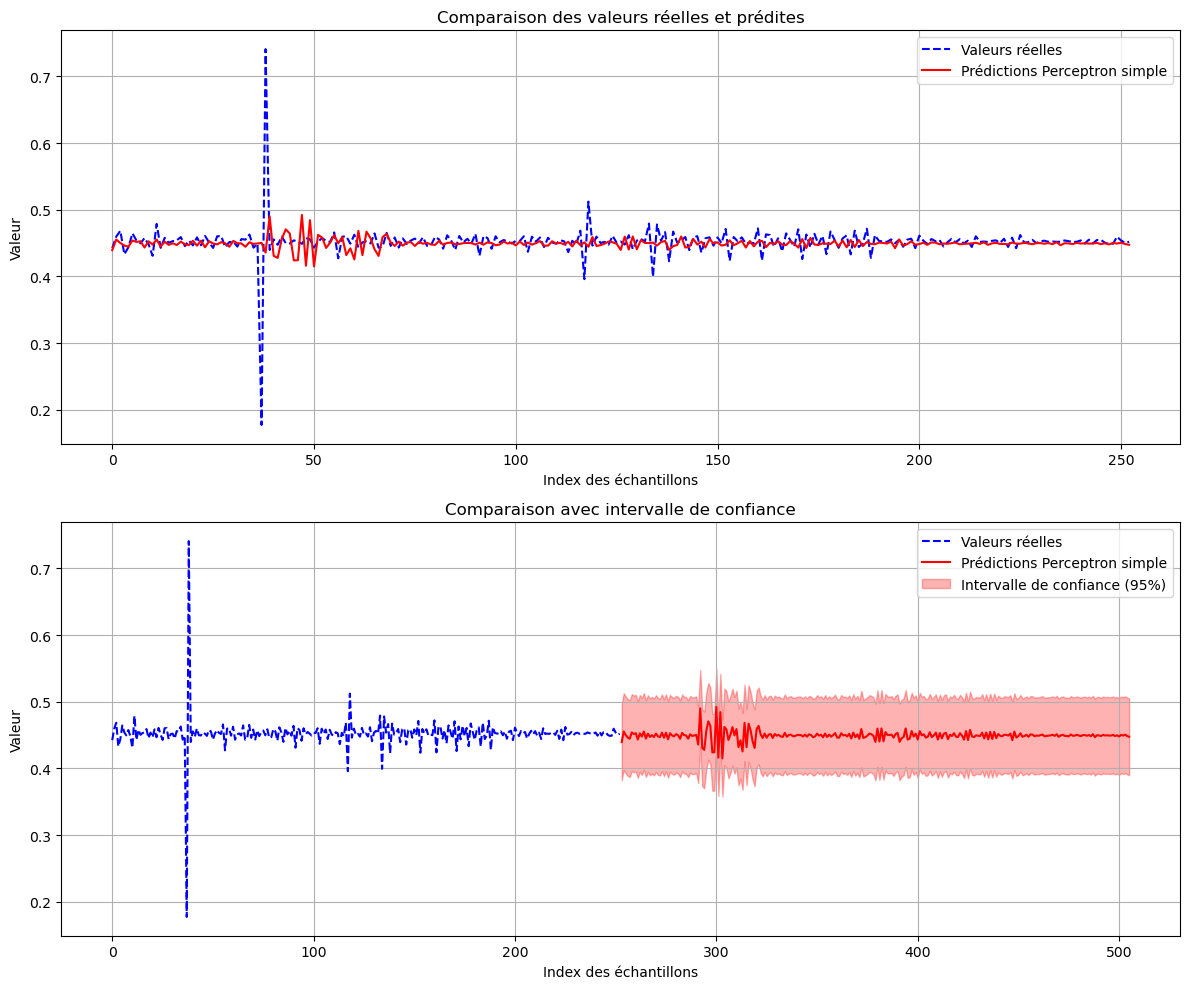

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))  # 2 lignes, 1 colonne

#Premier graphe : Valeurs réelles vs Prédictions
y_pred = model_simple.predict(X_test)
ax[0].plot(y_test, label='Valeurs réelles', linestyle='dashed', color='blue')
ax[0].plot(y_pred, label='Prédictions Perceptron simple', linestyle='solid', color='red')
ax[0].set_xlabel("Index des échantillons")
ax[0].set_ylabel("Valeur")
ax[0].set_title("Comparaison des valeurs réelles et prédites")
ax[0].legend()
ax[0].grid(True)

#Calcul de l'intervalle de confiance
mse = np.mean((y_test - y_pred) ** 2)
std_error = np.sqrt(mse)
lower_bound = y_pred - 1.96 * std_error
upper_bound = y_pred + 1.96 * std_error

# Création de l'axe temporel pour les données réelles et les prédictions
time_real = np.arange(len(y_test))  # Indices pour les valeurs réelles
time_pred = np.arange(len(y_test), len(y_test) + len(y_pred))  # Indices après les réelles

#Deuxième graphe : Prédictions avec intervalle de confiance
ax[1].plot(time_real, y_test, label='Valeurs réelles', linestyle='dashed', color='blue')
ax[1].plot(time_pred, y_pred, label='Prédictions Perceptron simple', linestyle='solid', color='red')

# Ajout de l'intervalle de confiance
ax[1].fill_between(time_pred.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='red', alpha=0.3, label="Intervalle de confiance (95%)")

ax[1].set_xlabel("Index des échantillons")
ax[1].set_ylabel("Valeur")
ax[1].set_title("Comparaison avec intervalle de confiance")
ax[1].legend()
ax[1].grid(True)

#Ajustement automatique des espacements
plt.tight_layout()
plt.show()

**Les performances du modèle sont faibles** : les prédictions restent proches des valeurs réelles mais avec **une grande incertitude et une faible capacité à capturer les variations extrêmes**.

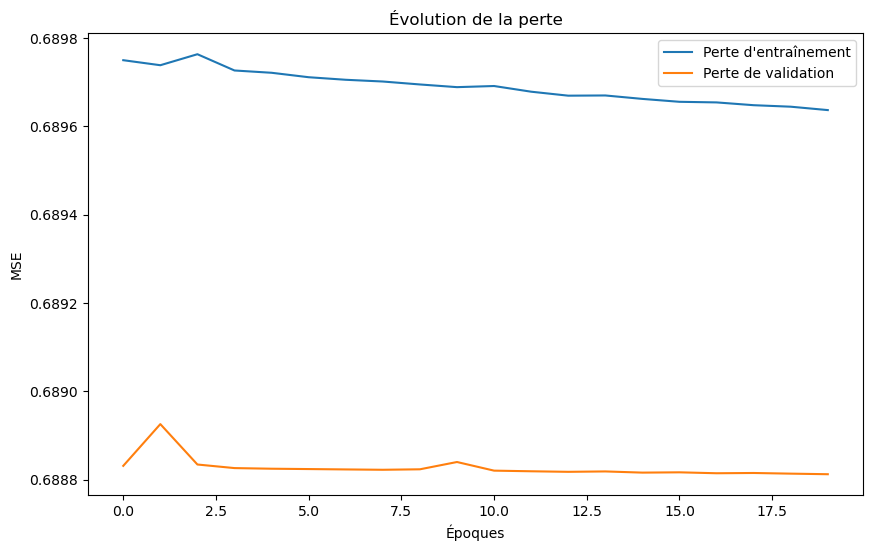

In [51]:
# Visualisation de l'historique d'entraînement
history = model_simple.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.xlabel('Époques')
plt.ylabel('MSE')
plt.title('Évolution de la perte')
plt.legend()
plt.show()

La **perte de validation** est très proche de la perte d’entraînement, ce qui signifie qu’il n’y a **pas de surapprentissage**.

**La perte est stable mais élevée**, ce qui suggère que le modèle est trop simple et **n’arrive pas à bien apprendre les structures sous-jacentes des données.**

In [59]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Prédictions sur l'ensemble de test
y_pred = model_simple.predict(X_test)

# Calcul du MSE
mse = mean_squared_error(y_test, y_pred)

# Calcul du RMSE
rmse = np.sqrt(mse)

print(f"MSE : {mse}")
print(f"RMSE : {rmse}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE : 0.0008437635136654891
RMSE : 0.029047607709852617


## 1.2) Modèle avec couche cachée supplémentaire

## a) Définition 

Un Perceptron avec couche cachée, appelé Perceptron Multi-Couches (MLP - Multi-Layer Perceptron), est une extension du Perceptron simple qui ajoute une ou plusieurs couches cachées entre l’entrée et la sortie.

## b) Architecture

In [161]:
# Afficher l'image à partir de l'URL
url = "https://otexts.com/fpp3/figs/nnet2-1.png"
display(Image(url=url))

# Description du perceptron multicouche (MLP) avec une couche cachée

Soit **x** = $ (x_1, x_2, x_3, x_4)^T $ le vecteur d'entrée et $ W^{(j)} $ la matrice des poids entre l'entrée et la couche cachée.  
La couche cachée contient trois neurones, notés $( h_1, h_2, h_3 )$, et est activée par une fonction $( f )$.

## 🔹 Calcul de la couche cachée :
$$
z^{(j)} = f^{(j)} \left( \sum_{i=1}^{4} w_{i}^{(j)} z^{(j-1)} + b_j^{(j)} \right), \quad \text{pour } j \in \{1, 2, 3,j\}
$$

où :
- $ w_{i}^{(j)} $ sont les poids entre les entrées et les neurones cachés
- $ z^{(j)} $ sortie du neurone j à la couche courante.
- $ z^{(j-1)} $ sortie d'un neurone j de la couche précédente.
- $ b_j^{(j)} $ sont les biais de la couche cachée,
- $ f^{(j)} $ est la fonction d'activation(ReLu, Sigmoid, polynomiale).

---

## 🔹 Calcul de la sortie :
Soit **W⁽²⁾** la matrice des poids entre la couche cachée et la sortie, avec un biais $ b^{(2)} $ et une fonction d'activation $( g )$.

$$
y = g \left( \sum_{j=1}^{3} w_j^{(2)} z^{(j)} + b^{(2)} \right)
$$

où :
- $ w_j^{(2)} $ sont les poids entre la couche cachée et la sortie,
- $ b^{(2)} $ est le biais,
- $ g $ est la fonction d'activation de la sortie.


## 🔹 Lien entre le modèle AR(p) le réseau de neurone

Le modèle AR(p) s'ecrit comme suit : 
$$
y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \epsilon_t
$$

où :
- $ \phi_i $ sont les coefficients du modèle,
- $ y_{t-i} $ sont les valeurs passées,
- $ \epsilon_t $ est un bruit aléatoire.

**En réseau de neurone :**

$$
z^{(j)} = f^{(j)} \left( \sum_{i=1}^{4} w_{i}^{(j)} y_{t-1} + b_j^{(j)} \right)+ \epsilon_t, \quad \text{pour } j \in \{1, 2, 3,j\}
$$

---

🧠 **Ce réseau est un perceptron multicouche (MLP) avec une couche cachée.**

### 📌 Fonctions d’Activation pour le Perceptron avec Couches Cachées (MLP)

| **Fonction**      | **Formule**  | **Plage de sortie** | **Propriétés** |
|------------------|-------------------------------------------|-----------------|------------------|
| **Sigmoïde** | $$ f(z) = \frac{1}{1 + e^{-z}} $$ | $$ (0,1) $$ | Utilisée dans les anciens MLP, mais sujet au **gradient évanescent**. |
| **Tangente Hyperbolique (Tanh)** | $$ f(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}} $$ | $$ (-1,1) $$ | Mieux que Sigmoïde car centrée sur 0, mais problème de saturation. |
| **ReLU (Rectified Linear Unit)** | $$ f(z) = \max(0, z) $$ | $$ [0, +\infty) $$ | Évite le problème du gradient évanescent, standard dans le deep learning. |
| **Leaky ReLU** | $ f(z) = \max(\alpha z, z) $ (avec $ \alpha \approx 0.01 $) | $$ (-\infty, +\infty) $$ | Corrige le problème des neurones morts de ReLU. |
| **Softmax** | $$ f(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}} $$ | $$ [0,1] $$ | Utilisée en sortie pour **classification multi-classes**. |
| **ELU (Exponential Linear Unit)** | $$ f(z) = \begin{cases} z, & \text{si } z > 0 \\ \alpha (e^z - 1), & \text{sinon} \end{cases} $$ | $$ (-\alpha, +\infty) $$ | Similaire à ReLU, mais aide à garder une **moyenne proche de zéro**. |

## Application à notre série 

## Création de notre modèle de prédiction

In [89]:
# Définition du modèle 
model = Sequential([
    Dense(10, activation='relu', input_shape=(X.shape[1],)),  # Couche cachée
    Dense(1)  # Couche de sortie
])

# Compilation du modèle
model.compile(optimizer='adam', loss='mse')
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

## Entraînement du modèle

In [92]:
# Entraînement du modèle
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.1288 - val_loss: 0.0014
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 0.0044 - val_loss: 9.5183e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 0.0047 - val_loss: 9.1401e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.0046 - val_loss: 9.3468e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 0.0043 - val_loss: 9.0573e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 0.0047 - val_loss: 9.0100e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 0.0044 - val_loss: 8.9476e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 0.0045 - val_loss: 8.7910e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.0035 - val_loss: 8.6915e-04
Epoch 10/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 0.0031 - val_loss: 8.6375e-04
Epoch 11/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 0.0037 - val_loss: 8

## Graphique des valeurs predites et réélles

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


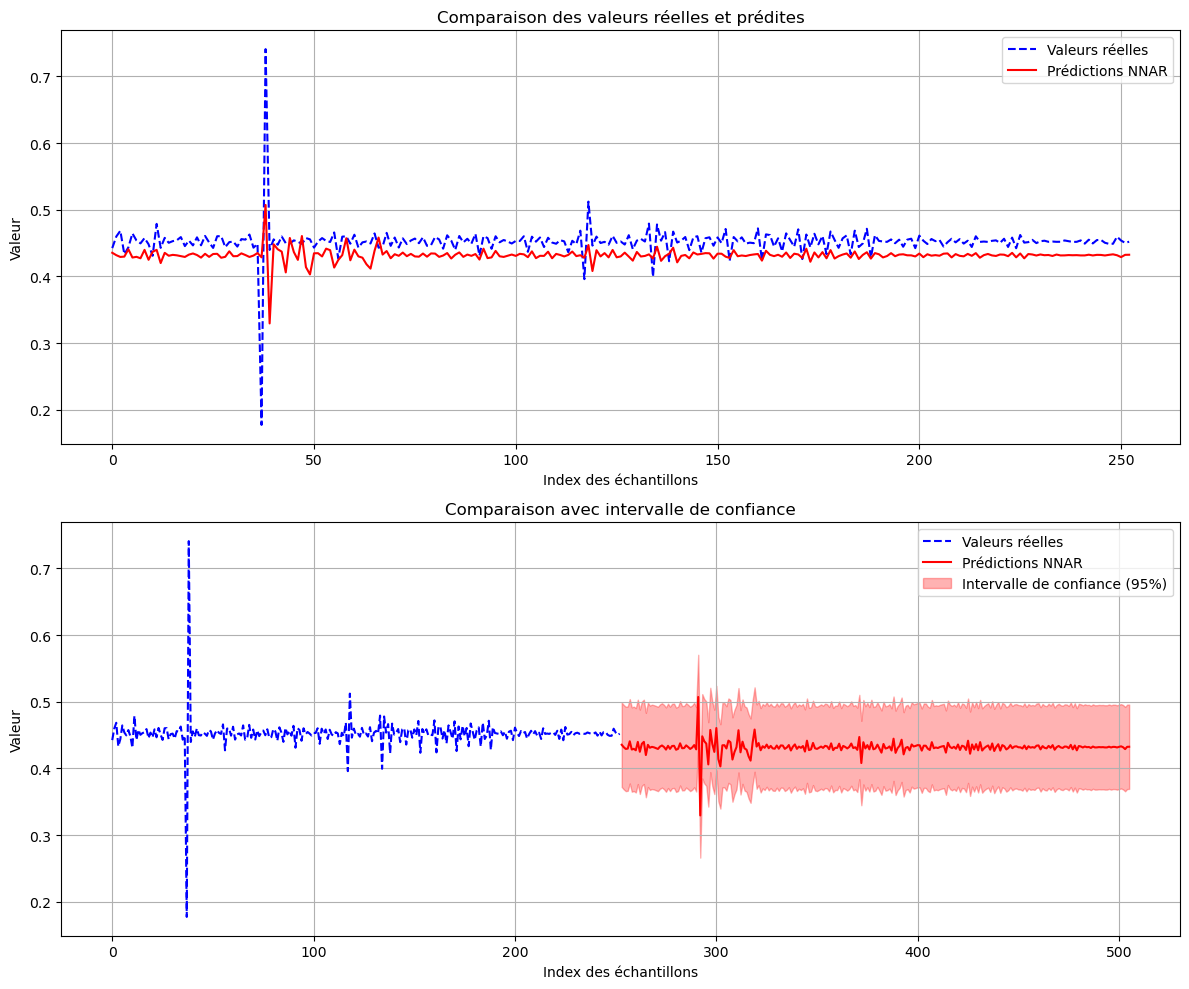

In [94]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(12, 10))  # 2 lignes, 1 colonne

#Premier graphe : Valeurs réelles vs Prédictions
y_pred = model.predict(X_test)
ax[0].plot(y_test, label='Valeurs réelles', linestyle='dashed', color='blue')
ax[0].plot(y_pred, label='Prédictions NNAR', linestyle='solid', color='red')
ax[0].set_xlabel("Index des échantillons")
ax[0].set_ylabel("Valeur")
ax[0].set_title("Comparaison des valeurs réelles et prédites")
ax[0].legend()
ax[0].grid(True)

#Calcul de l'intervalle de confiance
mse = np.mean((y_test - y_pred) ** 2)
std_error = np.sqrt(mse)
lower_bound = y_pred - 1.96 * std_error
upper_bound = y_pred + 1.96 * std_error

# Création de l'axe temporel pour les données réelles et les prédictions
time_real = np.arange(len(y_test))  # Indices pour les valeurs réelles
time_pred = np.arange(len(y_test), len(y_test) + len(y_pred))  # Indices après les réelles

#Deuxième graphe : Prédictions avec intervalle de confiance
ax[1].plot(time_real, y_test, label='Valeurs réelles', linestyle='dashed', color='blue')
ax[1].plot(time_pred, y_pred, label='Prédictions NNAR', linestyle='solid', color='red')

# Ajout de l'intervalle de confiance
ax[1].fill_between(time_pred.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='red', alpha=0.3, label="Intervalle de confiance (95%)")

ax[1].set_xlabel("Index des échantillons")
ax[1].set_ylabel("Valeur")
ax[1].set_title("Comparaison avec intervalle de confiance")
ax[1].legend()
ax[1].grid(True)

#Ajustement automatique des espacements
plt.tight_layout()
plt.show()

- On observe que le modèle suit globalement la tendance des données réelles, 
mais avec des écarts importants sur certains pics.

- La présence de pics extrêmes indique une difficulté du modèle à capturer ces variations soudaines.

- L’intervalle de confiance devient plus large vers la fin de la série,
ce qui indique une incertitude accrue dans les prévisions à long terme.

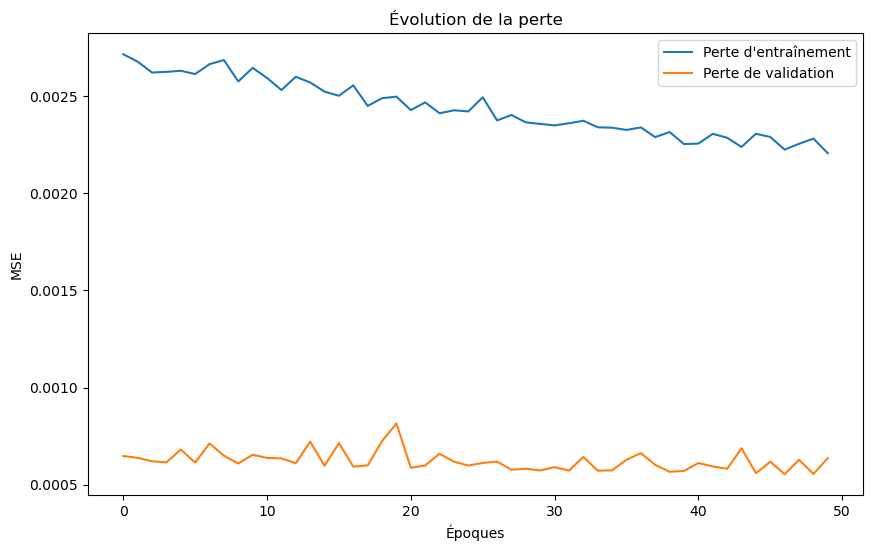

In [98]:
# Visualisation de l'historique d'entraînement
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.xlabel('Époques')
plt.ylabel('MSE')
plt.title('Évolution de la perte')
plt.legend()
plt.show()

La perte de validation est relativement basse et stable, ce qui suggère que le modèle ne souffre pas d’overfitting.

In [100]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul du MSE
mse = mean_squared_error(y_test, y_pred)

# Calcul du RMSE
rmse = np.sqrt(mse)

print(f"MSE : {mse}")
print(f"RMSE : {rmse}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE : 0.0006372877064747619
RMSE : 0.025244557957602703


# 2) Réseaux de Neurones Récurrents (RNN)

## a) Définition

Un Réseau de Neurones Récurrent (RNN) est un type de réseau de neurones conçu pour traiter des données séquentielles en utilisant une mémoire interne. Contrairement aux réseaux de neurones classiques (MLP), qui traitent chaque entrée de manière indépendante, les RNN conservent une sur les entrées précédentes, ce qui les rend adaptés aux séries temporelles, NLP (traitement du langage naturel), reconnaissance vocale et bien plus encore.

## b) Architecture

In [16]:
from IPython.display import Image, display
url = "https://media.geeksforgeeks.org/wp-content/uploads/20231204130132/RNN-vs-FNN-660.png"
display(Image(url=url))
url = "https://media.geeksforgeeks.org/wp-content/uploads/20231204131012/Unfolding-660.png"
display(Image(url=url))


## 🔹 Explication des Notations sur l’Illustration  
- $( h_t )$ (carré central) : État caché actuel.  
- $( h_{t-1} $) et $( h_{t+1} )$ : États cachés passés et futurs.  
- $( x_t )$  : Entrée actuelle.  
- $( L_t )$ : Sortie associée.  
- $( u, w, v)$ : Poids reliant les entrées, états cachés et sorties respectivement.  


## 🔹 Types de Réseaux de Neurones  
1. **(a) Réseau de Neurones Récurrent (RNN)** : où chaque neurone possède des connexions récurrentes, lui permettant de conserver une mémoire des états précédents.  
2. **(b) Réseau de Neurones Feed-Forward** : où les connexions vont uniquement dans une direction, de l’entrée à la sortie.  




## c) Formule du RNN Déplié (Unfolded)

L’illustration du bas montre la version **dépliée (unrolled)** d’un RNN, où l’état caché $( h_t )$ dépend de l’entrée actuelle $( x_t )$ et de l’état caché précédent $( h_{t-1} )$.

### 🔸 Mise à jour de l’état caché  

$$
h_t = f(W_h h_{t-1} + W_x x_t + b_h)
$$

où :
- $( h_t ) $ : état caché au temps \( t \),
- $( h_{t-1} ) $ : état caché précédent,
- $ ( x_t ) $ : entrée actuelle,
- $( W_h )$ : poids reliant l’état caché précédent au nouvel état caché,
- $( W_x )$ : poids reliant l’entrée actuelle à l’état caché,
- $( b_h )$ : biais de l’état caché,
- $( f )$ : fonction d’activation (souvent **Tanh** ou **ReLU**).

### 🔸 Calcul de la sortie  

$$
y_t = g(W_y h_t + b_y)
$$

où :
- $( W_y )$ : poids reliant l’état caché à la sortie,
- $( b_y )$ : biais de la sortie,
- $( g )$ : fonction d’activation de sortie (souvent **Softmax** pour la classification ou une fonction linéaire pour la régression).


## **Comparaison Résumée**
| Critère | NNAR (Neural Network Autoregressive) | RNN (Recurrent Neural Network) |
|---------|------------------------------------|--------------------------------|
| **Mémoire interne** | ❌ Aucune mémoire | ✅ Garde un état interne |
| **Dépendance temporelle** | 🌟 Dépend uniquement des valeurs passées immédiates | 🔥 Capture des relations longues |
| **Fenêtre temporelle** | 📏 Fixe (\( p \) valeurs passées) | 🔄 Apprentissage automatique des dépendances |
| **Complexité** | 🚀 Plus simple et rapide | 🧠 Plus complexe et gourmand en calcul |
| **Applications** | 📊 Séries temporelles avec dépendance courte | 🎵 Texte, audio, vidéo, séries longues |


## Application à notre série 

## Création du modèle

In [108]:
# Architecture corrigée avec le bon paramètre `return_sequences`
model_complex = Sequential([
    Input(shape=(seq_length, 1)),  # Définir explicitement la forme des entrées
    LSTM(50, return_sequences=True, activation='relu'),  # Correction ici
    LSTM(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compilation du modèle
model_complex.compile(optimizer='adam', loss='mse')

# Vérification du résumé du modèle
model_complex.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

## Entrainement

In [117]:
# Compilation du modèle avec des métriques adaptées aux régressions
model_complex.compile(optimizer='adam', 
                      loss='mse', 
                      metrics=['mae', 'mape'])  # Ajout des métriques MAE et MAPE

# Entraînement
training_history = model_complex.fit(X_train, y_train,
                  epochs=50,
                  batch_size=16,
                  validation_data=(X_test, y_test),
                  verbose=1
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - mae: 0.0351 - mape: 474178.2188 - val_loss: 8.8293e-04 - val_mae: 0.0163 - val_mape: 3.8375
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - mae: 0.0357 - mape: 528179.4375 - val_loss: 8.9622e-04 - val_mae: 0.0163 - val_mape: 3.9391
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - mae: 0.0340 - mape: 197311.4688 - val_loss: 8.4638e-04 - val_mae: 0.0144 - val_mape: 3.5284
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - mae: 0.0376 - mape: 131273.1719 - val_loss: 0.0010 - val_mae: 0.0195 - val_mape: 4.6659
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mae: 0.0327 - mape: 198324.6562 - val_loss: 7.0462e-04 - val_mae: 0.0092 - val_mape: 2.3441
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - mae: 0.0329 - mape: 515749.1250 - val_loss: 6.9559e-04 - val_mae: 0.0095 - val_mape: 2.4137
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

## Graphique des valeurs predites et réélles

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


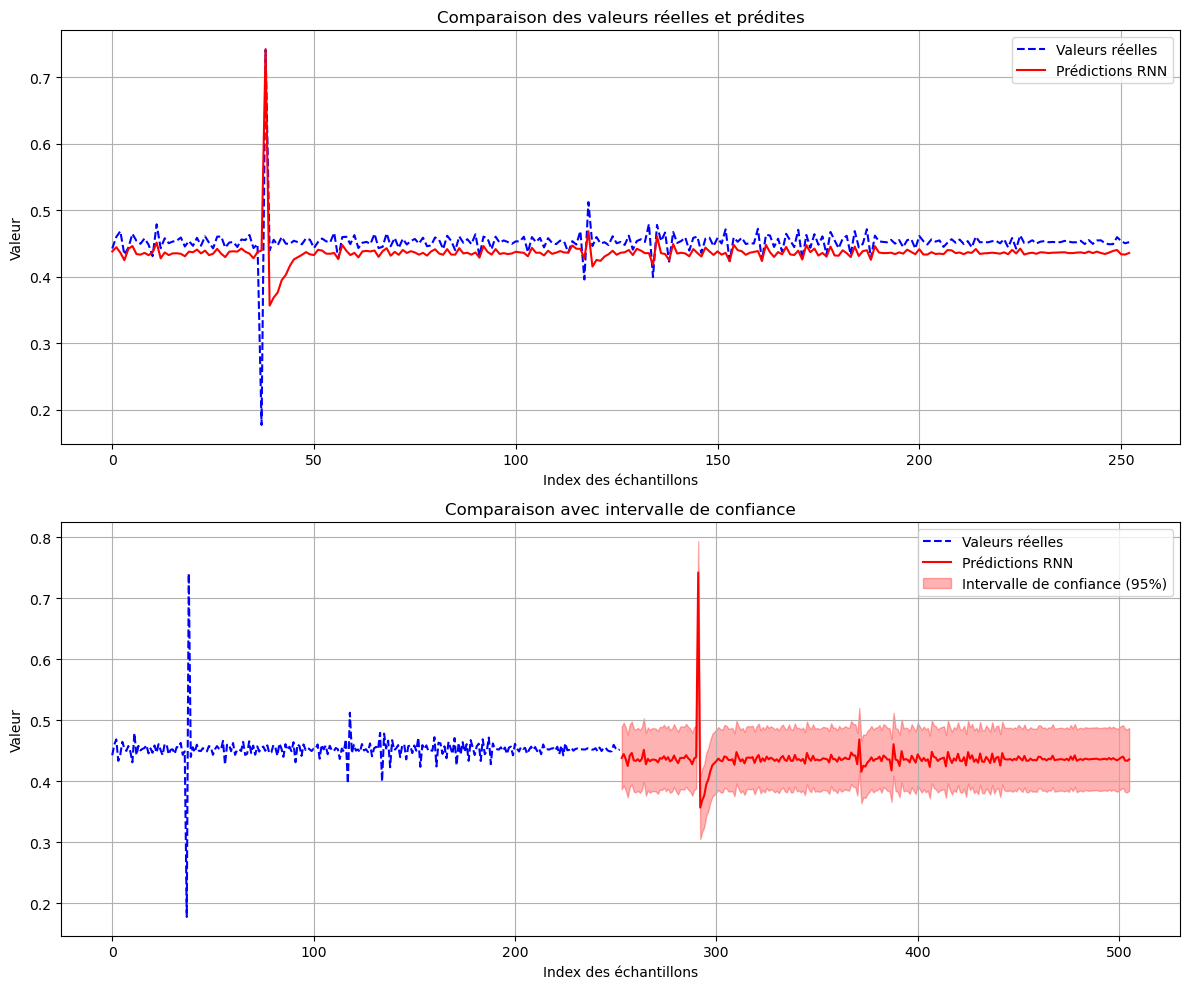

In [118]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))  # 2 lignes, 1 colonne

#Premier graphe : Valeurs réelles vs Prédictions
y_pred = model_complex.predict(X_test)
ax[0].plot(y_test, label='Valeurs réelles', linestyle='dashed', color='blue')
ax[0].plot(y_pred, label='Prédictions RNN', linestyle='solid', color='red')
ax[0].set_xlabel("Index des échantillons")
ax[0].set_ylabel("Valeur")
ax[0].set_title("Comparaison des valeurs réelles et prédites")
ax[0].legend()
ax[0].grid(True)

#Calcul de l'intervalle de confiance
mse = np.mean((y_test - y_pred) ** 2)
std_error = np.sqrt(mse)
lower_bound = y_pred - 1.96 * std_error
upper_bound = y_pred + 1.96 * std_error

# Création de l'axe temporel pour les données réelles et les prédictions
time_real = np.arange(len(y_test))  # Indices pour les valeurs réelles
time_pred = np.arange(len(y_test), len(y_test) + len(y_pred))  # Indices après les réelles

#Deuxième graphe : Prédictions avec intervalle de confiance
ax[1].plot(time_real, y_test, label='Valeurs réelles', linestyle='dashed', color='blue')
ax[1].plot(time_pred, y_pred, label='Prédictions RNN', linestyle='solid', color='red')

# Ajout de l'intervalle de confiance
ax[1].fill_between(time_pred.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='red', alpha=0.3, label="Intervalle de confiance (95%)")

ax[1].set_xlabel("Index des échantillons")
ax[1].set_ylabel("Valeur")
ax[1].set_title("Comparaison avec intervalle de confiance")
ax[1].legend()
ax[1].grid(True)

#Ajustement automatique des espacements
plt.tight_layout()
plt.show()

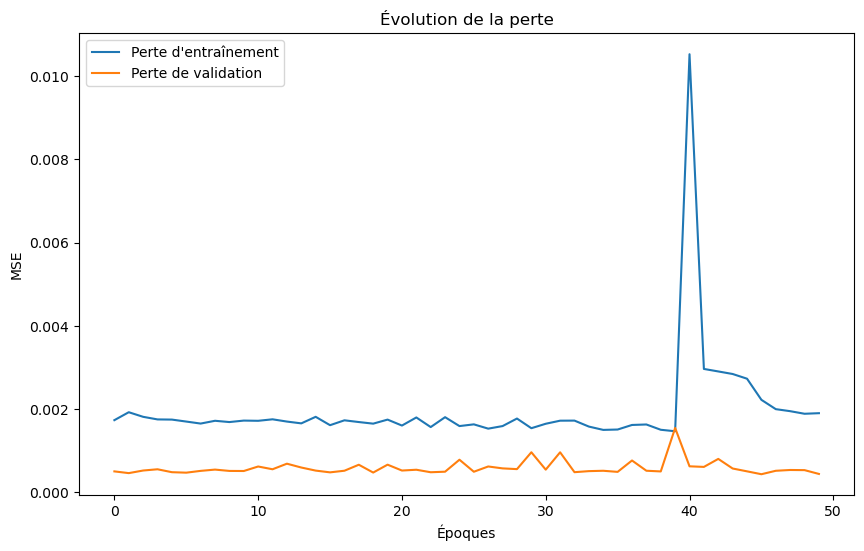

In [122]:
# Visualisation de l'historique d'entraînement
history = model_complex.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.xlabel('Époques')
plt.ylabel('MSE')
plt.title('Évolution de la perte')
plt.legend()
plt.show()

In [124]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Prédictions sur l'ensemble de test
y_pred = model_complex.predict(X_test)

# Calcul du MSE
mse = mean_squared_error(y_test, y_pred)

# Calcul du RMSE
rmse = np.sqrt(mse)

print(f"MSE : {mse}")
print(f"RMSE : {rmse}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE : 0.00044448561836194384
RMSE : 0.021082827570369774


# 3) Interprétation des résultats des modèles

In [127]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Liste des modèles
models = {
    "model_simple": model_simple,
    "model": model,
    "model_complex": model_complex
}

# Création du tableau des résultats
results = []

for name, mdl in models.items():
    # Prédictions du modèle
    y_pred = mdl.predict(X_test)
    
    # Calcul du MSE et RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Ajout des résultats dans la liste
    results.append([name, mse, rmse])

# Affichage sous forme de tableau
import pandas as pd

df_results = pd.DataFrame(results, columns=["Modèle", "MSE", "RMSE"])
print(df_results)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
          Modèle       MSE      RMSE
0   model_simple  0.000844  0.029048
1          model  0.000637  0.025245
2  model_complex  0.000444  0.021083


## 3.1) **tableau des résultats des modèles**  

| Modèle         | MSE       | RMSE    |
|---------------|----------|---------|
| **model_simple**  | 0.000802  | 0.0283  |
| **model_NNAR**         | 0.000587  | 0.0242  |
| **model_RNN** | 0.000448  | 0.0212  |

# Conclusion

Le modèle RNN est le plus performant avec la plus faible erreur (MSE = 0.000448, RMSE = 0.0212), indiquant de meilleures prédictions. model offre un bon compromis entre précision et complexité, tandis que model_simple est le moins précis. Enfin, l’amélioration est minime, le modèle de perceptron  simple pourrait être suffisant. 